In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kaggle


In [7]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d diversisai/fire-segmentation-image-dataset

100% 471M/472M [00:23<00:00, 24.5MB/s]
100% 472M/472M [00:23<00:00, 20.9MB/s]


In [11]:
!unzip /content/fire-segmentation-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Segmentation_Mask/Fire/Img_5374.jpg  
  inflating: Segmentation_Mask/Fire/Img_5375.jpg  
  inflating: Segmentation_Mask/Fire/Img_5376.jpg  
  inflating: Segmentation_Mask/Fire/Img_5377.jpg  
  inflating: Segmentation_Mask/Fire/Img_5378.jpg  
  inflating: Segmentation_Mask/Fire/Img_5379.jpg  
  inflating: Segmentation_Mask/Fire/Img_538.jpg  
  inflating: Segmentation_Mask/Fire/Img_5380.jpg  
  inflating: Segmentation_Mask/Fire/Img_5381.jpg  
  inflating: Segmentation_Mask/Fire/Img_5382.jpg  
  inflating: Segmentation_Mask/Fire/Img_5383.jpg  
  inflating: Segmentation_Mask/Fire/Img_5384.jpg  
  inflating: Segmentation_Mask/Fire/Img_5385.jpg  
  inflating: Segmentation_Mask/Fire/Img_5386.jpg  
  inflating: Segmentation_Mask/Fire/Img_5387.jpg  
  inflating: Segmentation_Mask/Fire/Img_5388.jpg  
  inflating: Segmentation_Mask/Fire/Img_5389.jpg  
  inflating: Segmentation_Mask/Fire/Img_539.jpg  
  inflating: Segmentation_Mask/Fi

In [12]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras


seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [13]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        image_path = os.path.join("/content/Image/Fire", id_name)
        mask_path = os.path.join("/content/Segmentation_Mask/Fire", id_name)
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))

        mask = np.zeros((self.image_size, self.image_size, 1))

        _mask_image = cv2.imread(mask_path, -1)
        _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size))
        _mask_image = np.expand_dims(_mask_image, axis=-1)
        mask = np.maximum(mask, _mask_image)


        image = image/255.0
        mask = mask/255.0

        return image, mask

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        image = []
        mask  = []

        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [14]:
image_size = 64

train_path = "/content/Image/Fire"
epochs = 10

batch_size = 10


train_ids = next(os.walk(train_path))[2]


val_data_size = 100

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]
print(valid_ids)
print(train_ids)

['Img_16437.jpg', 'Img_4207.jpg', 'Img_1283.jpg', 'Img_21221.jpg', 'Img_4205.jpg', 'Img_5840.jpg', 'Img_18577.jpg', 'Img_21883.jpg', 'Img_16493.jpg', 'Img_16459.jpg', 'Img_18828.jpg', 'Img_21941.jpg', 'Img_3372.jpg', 'Img_12140.jpg', 'Img_3011.jpg', 'Img_9585.jpg', 'Img_6261.jpg', 'Img_24278.jpg', 'Img_5311.jpg', 'Img_20936.jpg', 'Img_327.jpg', 'Img_8206.jpg', 'Img_7977.jpg', 'Img_22635.jpg', 'Img_20246.jpg', 'Img_16393.jpg', 'Img_12856.jpg', 'Img_9756.jpg', 'Img_13165.jpg', 'Img_7256.jpg', 'Img_111.jpg', 'Img_4422.jpg', 'Img_4539.jpg', 'Img_23619.jpg', 'Img_21739.jpg', 'Img_21990.jpg', 'Img_265.jpg', 'Img_17745.jpg', 'Img_21486.jpg', 'Img_17622.jpg', 'Img_16491.jpg', 'Img_489.jpg', 'Img_27151.jpg', 'Img_7550.jpg', 'Img_15654.jpg', 'Img_23952.jpg', 'Img_1182.jpg', 'Img_16718.jpg', 'Img_17381.jpg', 'Img_14653.jpg', 'Img_23845.jpg', 'Img_20231.jpg', 'Img_16430.jpg', 'Img_21925.jpg', 'Img_8363.jpg', 'Img_20679.jpg', 'Img_13014.jpg', 'Img_7300.jpg', 'Img_6735.jpg', 'Img_2257.jpg', 'Img_193

In [15]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(10, 64, 64, 3) (10, 64, 64, 1)


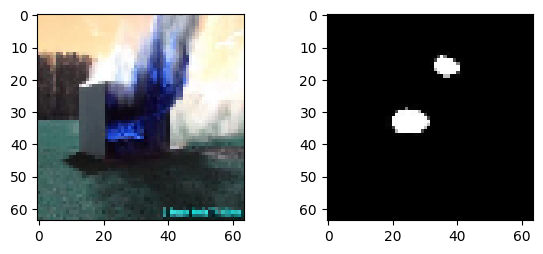

In [16]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [17]:
kernel_size=(3,3)
padding='same'
strides=1
inputs = keras.layers.Input((image_size, image_size, 3))
c1 = keras.layers.Conv2D(16, kernel_size, padding=padding, strides=strides, activation="relu")(inputs)
c1 = keras.layers.Conv2D(16, kernel_size, padding=padding, strides=strides, activation="relu")(c1)
p1 = keras.layers.MaxPool2D((2, 2), (2, 2))(c1)

c2 = keras.layers.Conv2D(32, kernel_size, padding=padding, strides=strides, activation="relu")(p1)
c2 = keras.layers.Conv2D(32, kernel_size, padding=padding, strides=strides, activation="relu")(c2)
p2 = keras.layers.MaxPool2D((2, 2), (2, 2))(c2)

c3 = keras.layers.Conv2D(64, kernel_size, padding=padding, strides=strides, activation="relu")(p2)
c3 = keras.layers.Conv2D(64, kernel_size, padding=padding, strides=strides, activation="relu")(c3)
p3 = keras.layers.MaxPool2D((2, 2), (2, 2))(c3)

c4 = keras.layers.Conv2D(128, kernel_size, padding=padding, strides=strides, activation="relu")(p3)
c4 = keras.layers.Conv2D(128, kernel_size, padding=padding, strides=strides, activation="relu")(c4)
p4 = keras.layers.MaxPool2D((2, 2), (2, 2))(c4)

bn = keras.layers.Conv2D(256, kernel_size, padding=padding, strides=strides, activation="relu")(p4)
bn = keras.layers.Conv2D(256, kernel_size, padding=padding, strides=strides, activation="relu")(bn)

us = keras.layers.UpSampling2D((2, 2))(bn)
concat = keras.layers.Concatenate()([us, c4])
d1 = keras.layers.Conv2D(128, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
d1 = keras.layers.Conv2D(128, kernel_size, padding=padding, strides=strides, activation="relu")(d1)

us1 = keras.layers.UpSampling2D((2, 2))(d1)
concat = keras.layers.Concatenate()([us1, c3])
d2 = keras.layers.Conv2D(64, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
d2= keras.layers.Conv2D(64, kernel_size, padding=padding, strides=strides, activation="relu")(d2)

us2 = keras.layers.UpSampling2D((2, 2))(us1)
concat = keras.layers.Concatenate()([us2, c2])
d3 = keras.layers.Conv2D(32, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
d3 = keras.layers.Conv2D(32, kernel_size, padding=padding, strides=strides, activation="relu")(d3)

us3 = keras.layers.UpSampling2D((2, 2))(us2)
concat = keras.layers.Concatenate()([us3, c1])
d4 = keras.layers.Conv2D(16, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
d4 = keras.layers.Conv2D(16, kernel_size, padding=padding, strides=strides, activation="relu")(d4)
outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
model = keras.models.Model(inputs, outputs)


In [18]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 16)           448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 16)           2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,
                    validation_steps=valid_steps, epochs=10)

Epoch 1/10


<ipython-input-19-77ddcb3db72d>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,


2736/2736 [==============================] - 80s 25ms/step - loss: 0.0350 - acc: 0.9721 - val_loss: 0.0254 - val_acc: 0.9740
Epoch 2/10
2736/2736 [==============================] - 68s 25ms/step - loss: 0.0237 - acc: 0.9742 - val_loss: 0.0241 - val_acc: 0.9741
Epoch 3/10
2736/2736 [==============================] - 74s 27ms/step - loss: 0.0216 - acc: 0.9747 - val_loss: 0.0202 - val_acc: 0.9753
Epoch 4/10
2736/2736 [==============================] - 69s 25ms/step - loss: 0.0203 - acc: 0.9749 - val_loss: 0.0202 - val_acc: 0.9752
Epoch 5/10
2736/2736 [==============================] - 71s 26ms/step - loss: 0.0196 - acc: 0.9750 - val_loss: 0.0197 - val_acc: 0.9754
Epoch 6/10
2736/2736 [==============================] - 70s 26ms/step - loss: 0.0189 - acc: 0.9751 - val_loss: 0.0189 - val_acc: 0.9753
Epoch 7/10
1780/2736 [==================>...........] - ETA: 25s - loss: 0.0184 - acc: 0.9752

In [14]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [15]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))

    p0 = inputs
    c1, p1 = down_block(p0, f[0])  # 128 --> 64
    c2, p2 = down_block(p1, f[1])  # 64  --> 32
    c3, p3 = down_block(p2, f[2])  # 32  --> 16
    c4, p4 = down_block(p3, f[3])  # 16  --> 8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3])  # 8  --> 16
    u2 = up_block(u1, c3, f[2])  # 16 --> 32
    u3 = up_block(u2, c2, f[1])  # 32 --> 64
    u4 = up_block(u3, c1, f[0])  # 64 --> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [16]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 16)           448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 16)           2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
model.save_weights("UNetW.h5")


x, y = valid_gen.__getitem__(2)
result = model.predict(x)

result = result > 0.5

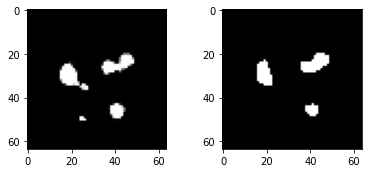

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

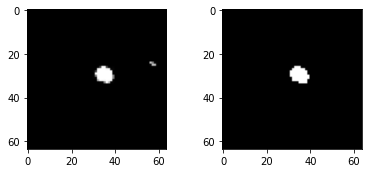

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")